# Training showcase

This notebooks shows how to perform a simple training step with the AIDA code.

### import basic modules

In [1]:
import torch
import matplotlib.pyplot as plt

### set the device for the calculations

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Set device to {device}.")

Set device to cpu.


### set data paths

In [3]:
grid_file = '/hpc/uwork/fe11bacy/invar_new/invar_0027_R03B08_L120_20231113_tiles.grb'
fg_path = '/hpc/uwork/tdeppisc/AIDA_data/ICON-EU'
synop_path = '/hpc/uwork/tdeppisc/AIDA_data/SYNOP'
output_path = 'showcase_output'

### define training time interval

In [4]:
from util import TimeSeries
valid_times = TimeSeries(
        start='20230510000000',
        end='20230510230000',
        step={'hours':3})

print(valid_times)

TimeSeries: 8 time steps from 20230510000000 until 20230510210000


### set domain boundaries

In [5]:
domain = {'lon_min': 7.5, 'lon_max': 8.5, 'lat_min': 49.5, 'lat_max': 50.5}

## load data for training

### Create an `ObservationDataset`

In [6]:
from observations import ObservationDataset
obs = ObservationDataset(valid_times=valid_times, domain=domain)

An `ObservationDataset` is a container for observations at different validity times. Let's add some observational data from feedback files:
  - add SYNOP observations from ICON reanalysis
  - specify the observations by the `observation_descriptions` keyword (varno 39 refers to 2m temperature)

In [7]:
obs.add_feedback_data(path=synop_path,
                      obs_type='SYNOP',
                      fdbk_type='mon',
                      model='ICON-EU',
                      n_obs=50,
                      observation_descriptions = [{"varno": 39, "obs_err": 1.0}])

Read feedback files of type monSYNOP from /hpc/uwork/tdeppisc/AIDA_data/SYNOP.
Data loading took 8.52s.


In [8]:
# use the `print` function to get an overview of the data:
print(obs)

ObservationDataset
  - validity times: TimeSeries: 8 time steps from 20230510000000 until 20230510210000
  - sample data for 20230510000000:
    ObservationCollection, contains 1 observational type(s):
      - SYNOP:
        SynopObservationData
         - values tensor: torch.Size([50, 5])
         - columns: ['obs', 'obs_err', 'varno', 'lon', 'lat']
         - complete: True


We see that `ObservationDataset` has a hierarchical structure: There is an `ObservationCollection` object for each time step which in turn contains an `ObservationData` object for each observation type ('TEMP', 'RAD', 'SYNOP',...). Each observation type has its own class associated with it. That way each observational system can have different types of meta data that is passed to the neural network. In this case we have an instance of `SynopObservationData`. Let's access its data directly:

In [9]:
obs.time_steps['20230510120000'].obs_types["SYNOP"].values

tensor([[288.8500,   1.0000,  39.0000,   7.9548,  49.9859],
        [289.5500,   1.0000,  39.0000,   7.9590,  49.9810],
        [290.5500,   1.0000,  39.0000,   8.4536,  49.8537],
        [288.8500,   1.0000,  39.0000,   8.1050,  50.2119],
        [287.1500,   1.0000,  39.0000,   7.6528,  50.4528],
        [289.7500,   1.0000,  39.0000,   7.5018,  50.3126],
        [289.0500,   1.0000,  39.0000,   7.9395,  50.4260],
        [284.7500,   1.0000,  39.0000,   7.5981,  49.9996],
        [289.6500,   1.0000,  39.0000,   7.7609,  50.0602],
        [288.9500,   1.0000,  39.0000,   7.6128,  49.7756],
        [291.1500,   1.0000,  39.0000,   7.5749,  49.6384],
        [288.1500,   1.0000,  39.0000,   7.8710,  49.8502],
        [291.2500,   1.0000,  39.0000,   8.0916,  50.0069],
        [289.1500,   1.0000,  39.0000,   8.0075,  49.9512],
        [290.3500,   1.0000,  39.0000,   8.1860,  49.9719],
        [288.8500,   1.0000,  39.0000,   7.9555,  49.9152],
        [289.6500,   1.0000,  39.0000,  

Each observation type _knows_ which data reside on which column of the tensor. We can find that information here

In [10]:
obs.time_steps['20230510120000'].obs_types["SYNOP"].column_descriptions

['obs', 'obs_err', 'varno', 'lon', 'lat']

Use that information to plot the data:

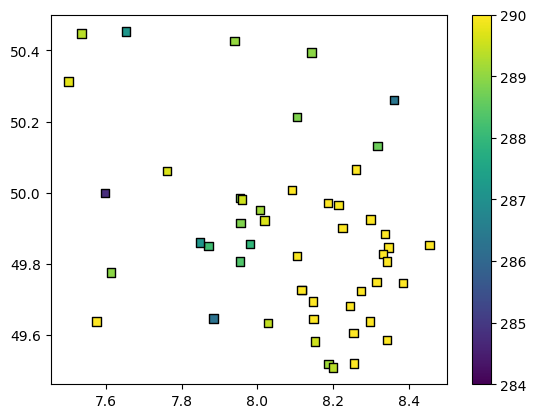

In [11]:
# define a reference to shorten the plotting commands:
foo = obs.time_steps['20230510120000'].obs_types["SYNOP"]

plt.scatter(
    foo.get_column('lon'),
    foo.get_column('lat'),
    c=foo.get_column('obs'),
    vmin=284., vmax=290., marker='s', edgecolor='k')
plt.colorbar()

### create ForecastDataset

Similar to `ObservationDataset`, a `ForecastDataset` contains a `ForecastData` object for each time step.

In [12]:
from forecasts import ForecastDataset
fg = ForecastDataset(valid_times=valid_times)

In order to load NWP model data we first need to define a grid by reading an `invar` file.

In [13]:
static_fields = {'CLON':0, 'CLAT':0} # grib identifier for invar file fields

fg.add_analysis_grid(
    grid_file=grid_file,
    model="ICON-EU",
    static_field_descriptions=static_fields,
    domain=domain,
    grid_3d=False)
print(fg.analysis_grid)

Create GridInformation from /hpc/uwork/fe11bacy/invar_new/invar_0027_R03B08_L120_20231113_tiles.grb

UnstructuredGrid
  - coordinates for 176 grid points
  - heights for 1 layers
  - interpolation method: barycentric
  - static fields:
    ForecastData
      - values tensor: torch.Size([2, 176])
      - layers: [['CLON', 0], ['CLAT', 0]]
      - complete: True


A `GridInformation` object contains the (2d and/or 3d) coordinates about the NWP grid as well as _static_ fields such as `HSURF` or `HHL`. The `GridInformation` object also can calculate interpolation indices and weights:

In [14]:
fg.analysis_grid.get_interpolation_data_2d(
    lons=torch.tensor([8.3]), lats=torch.tensor([49.6]))

(tensor([[119, 121, 126]], dtype=torch.int32),
 tensor([[0.0527, 0.4852, 0.4620]]))

Next we add some first guess fields from the ICON DREAM reanalysis.

In [15]:
fg_fields = {'T_2M':2} # grib identifier for background files

fg.add_ICON_fg(model="ICON-EU",
               layer_descriptions=fg_fields,
               path=fg_path,
               use_index_file=False)
print(fg)

Read [['T_2M', 2]] from ICON first guess data.

Data loading took 8.74s.
ForecastDataset
  - validity times: TimeSeries: 8 time steps from 20230510000000 until 20230510210000
  - analysis grid:
    UnstructuredGrid
      - coordinates for 176 grid points
      - heights for 1 layers
      - interpolation method: barycentric
      - static fields:
        ForecastData
          - values tensor: torch.Size([2, 176])
          - layers: [['CLON', 0], ['CLAT', 0]]
          - complete: True
  - sample data for 20230510000000:
    ForecastData
      - values tensor: torch.Size([1, 176])
      - layers: [['T_2M', 2]]
      - complete: True


access the data directly:

In [16]:
fg.time_steps["20230510120000"].values

tensor([[287.9613, 287.2690, 287.3070, 286.5385, 286.9301, 284.9750, 285.8158,
         285.5277, 286.5668, 285.3188, 285.6840, 286.3481, 285.0121, 284.6879,
         285.5346, 284.9652, 285.4838, 286.3158, 286.0180, 286.9291, 288.1957,
         288.9818, 289.0981, 288.8783, 287.0551, 287.3275, 286.5922, 286.2270,
         286.0541, 286.3842, 287.0336, 286.4115, 286.8734, 287.3148, 286.3217,
         286.6977, 287.5815, 286.6293, 286.2016, 287.2826, 287.4408, 286.1244,
         286.5492, 287.1703, 287.3500, 287.8793, 286.8588, 285.9857, 288.1781,
         287.9428, 288.1615, 288.0473, 287.5736, 286.9965, 287.7387, 288.0180,
         287.4516, 286.9565, 287.3022, 286.7680, 286.3578, 287.5463, 286.9281,
         287.2846, 287.2523, 286.4311, 287.0443, 286.5775, 286.8217, 287.1381,
         287.0307, 287.8695, 286.2885, 286.8061, 286.6166, 286.3090, 285.6010,
         287.0463, 285.7875, 285.7670, 288.0512, 286.3676, 287.3119, 287.3881,
         286.1840, 284.8168, 286.2504, 285.6547, 286

make a simple plot:

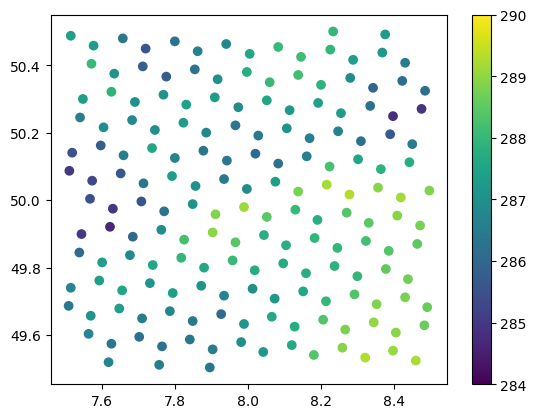

In [17]:
plt.scatter(
    fg.analysis_grid.lon,
    fg.analysis_grid.lat,
    c=fg.time_steps["20230510120000"].values,
    vmin=284., vmax=290.)
plt.colorbar()

### create a DADataset from obs and fg data sets

For use in Data Assimilation we need to combine the forecasts and observation into one `DADataset` object.

In [18]:
from datasets import DADataset
training_dataset = DADataset(obs, fg)

In machine learning it is customary to use one dataset for training and another one for validation. Here we just take a random portion for validation and perform some consistency checks on both datasets.

In [19]:
# chose 10% of data randomly for validation
validation_dataset = training_dataset.create_validation_dataset(random_fraction=0.1)

# check consistency of the dataset
training_dataset.check_completeness(if_incomplete="deleteData")
validation_dataset.check_completeness(if_incomplete="deleteData")

# print time steps
print("training dataset",training_dataset.valid_times)
print("validation dataset",validation_dataset.valid_times)

training dataset TimeSeries: 7 time steps from 20230510000000 until 20230510210000
validation dataset TimeSeries: 1 time steps from 20230510030000 until 20230510030000


Before we start training an ML model let us take a look at the data returned by the DADataset class:

In [20]:
print(training_dataset.test_batch)

{'fg': {'values': tensor([[[285.7055, 285.6440, 285.4359, 284.9955, 285.4584, 283.9731, 284.3949,
          284.3363, 284.8481, 284.0209, 284.1811, 284.6742, 283.7895, 283.5063,
          284.1371, 283.7465, 284.2836, 284.5941, 284.5570, 285.1176, 286.0463,
          286.4828, 286.7299, 286.5365, 285.1645, 285.4809, 284.5297, 284.3783,
          284.3188, 284.6440, 285.3197, 284.7299, 285.1176, 285.5561, 284.4613,
          284.8236, 285.6068, 284.9506, 284.9438, 285.5522, 285.4965, 285.1176,
          285.0717, 285.3754, 285.3979, 285.8754, 285.1283, 284.6586, 286.0356,
          285.5863, 285.8520, 285.7748, 285.6820, 285.5854, 285.9711, 286.0180,
          285.3803, 285.0190, 285.2406, 284.7143, 284.4047, 285.6713, 285.0307,
          285.4379, 285.3490, 284.6244, 285.1732, 284.6371, 284.9945, 285.2885,
          285.0932, 285.9428, 285.1459, 285.1244, 285.1606, 284.8871, 284.2680,
          285.8266, 284.5736, 284.6205, 286.5434, 284.6869, 285.2875, 285.0912,
          285.1781, 28

We note that:
- The observational data, the forecast data and the static fields from the grid information are combined. There is additional `'meta'` data that encodes the day of the year and the time of the day.
- Only 'plain' data is passed to the neural network since `torch` can only work with basic types (lists, dictionaries,...) and `torch.tensor` objects.
- Each observation comes with additional `'interpolation_data'` that contains the interpolation indices and weights to interpolate the NWP model state to the position of the observation.
- All tensors come with additional normalisation weights (called `'*_mean'` and `*_std`). The AIDA code knows from the meta data (grib identifier, varno, etc.) how to normalise each variable. Normalisation of the tensors can be 'row wise', 'column wise' or 'element wise'.
- All tensors have an additional 3rd dimension: the batch dimension. All operations of the neural network are vectorized so that multiple samples can be processed at once.

## Define a data assimilation model

This is a simple encoder-decoder ML model that has one encoder network for the forecast data and one encoder network for each observation type. The decoder network then projects back into the space of the analysis. Lastly, the forward operators for the specific observational types are called on the analysis fields. (In case of SYNOP observations, the forward operatore is merely a interpolation of the NWP fields to the position of the observation.)

Note that a test batch from the dataset is used to determine the shaps of the input tensors.

In [21]:
from models import DAAutoencoder, InSituFO
model = DAAutoencoder(
        n_target = 1, # one layer: T2M
        n_latent = 256,
        forward_operators = {"SYNOP": InSituFO()},
        activation = torch.nn.PReLU(),
        fg_emb_hidden = [],
        meta_emb_hidden = [],
        obs_emb_hidden = {"SYNOP": []},
        decoder_hidden = [],
        conv_kernel_size = 21,
        batch=training_dataset.test_batch)
print(model)

DAAutoencoder(
  (forward_op): ModuleDict(
    (SYNOP): InSituFO()
  )
  (norm): Normalizer()
  (fg_embedding): MLP(
    (0): Linear(in_features=528, out_features=256, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (meta_embedding): MLP(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (obs_embedding): ModuleDict(
    (SYNOP): MLP(
      (0): Linear(in_features=250, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
    )
  )
  (convolution): Conv1d(3, 1, kernel_size=(21,), stride=(1,), padding=(10,))
  (decoder): MLP(
    (0): Linear(in_features=256, out_features=176, bias=True)
    (1): PReLU(num_parameters=1)
  )
)
parameters: 245745
buffers: 0


Although the model has not yet been trained we can apply it to a batch of data:

In [22]:
sample = validation_dataset.test_batch
result = model(sample)
print(result)

{'fg': {'values': tensor([[[284.8068, 284.6037, 285.0617, 284.6369, 285.2169, 283.7384, 284.1398,
          284.0783, 284.6525, 283.7990, 283.9933, 284.4474, 283.3625, 283.1466,
          283.8244, 283.4211, 283.9494, 284.1789, 284.1212, 284.5812, 285.5168,
          285.7013, 286.1125, 285.8283, 284.7736, 285.0021, 283.9152, 283.9308,
          283.9298, 284.3029, 284.9660, 284.3693, 284.6925, 285.3136, 284.0441,
          284.4953, 285.3263, 284.2365, 284.0392, 284.8302, 284.8878, 284.1916,
          284.2921, 284.6486, 284.8556, 285.2668, 284.4816, 283.8918, 285.4152,
          284.9660, 285.2130, 284.9992, 284.9035, 284.9396, 285.2062, 285.1769,
          285.0910, 284.7091, 284.8605, 284.3029, 283.9474, 285.0734, 284.4992,
          284.9269, 284.7306, 284.1584, 284.5832, 283.9914, 284.7912, 285.0998,
          285.0011, 285.8156, 284.8527, 284.5285, 284.7062, 284.5871, 284.2736,
          285.7599, 284.5539, 284.5216, 286.3957, 284.7189, 285.2570, 285.0656,
          284.0617, 28

As we see, the model takes the first guess and observation as input and returns the analysis as well as the analysis in observation space.

## initiate loss function

The data assimilation functional is used as the loss function to optimize the ML model. For that we need to define all ingredients of
$$ J(x) = \alpha\ \lVert x-x_b \rVert_{B^{-1}}^2 + \lVert \mathcal{H}(x)-y \rVert_{R^{-1}}^2 $$
In that case we use Gaussian $B$ matrix (background field covariance) with a localisation radius of 20 km and a diagonal $R$ matrix (covariances of the observations) for the SYNOP observations.

In [23]:
from losses import DALoss, GaussianBMatrix, DiagonalRMatrix
loss_function = DALoss(
    alpha=.1,
    b_matrix=GaussianBMatrix(
        grid_information=fg.analysis_grid,
        layer_descriptions=fg[0].layer_descriptions,
        sigma_horz=20.,
        eps=.01),
    r_matrices={"SYNOP": DiagonalRMatrix(n_obs=50)})
print(loss_function)

DALoss(
  (b_matrix): GaussianBMatrix()
  (r_matrices): ModuleDict(
    (SYNOP): DiagonalRMatrix()
  )
)


Covariance matrices are split-up into a horizontal ('columns') and a vertical ('rows') part. Let's have a look at the B matrix (i.e. background error covariance).

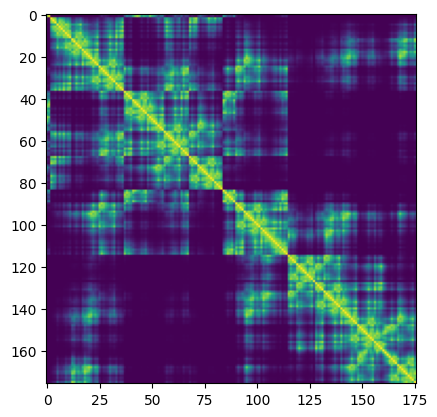

In [24]:
plt.imshow(loss_function.b_matrix.col_mat)
plt.savefig("aivar_B_matrix.png")

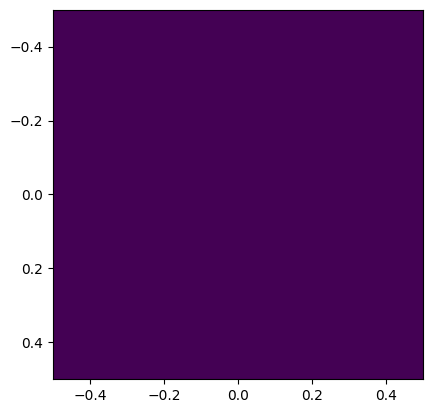

In [25]:
plt.imshow(loss_function.b_matrix.row_mat)

(There is but one vertical layer in the chosen setup.)

Now, apply the loss function to our testing sample:

In [26]:
loss_function(result)

tensor(5.0189, grad_fn=<AddBackward0>)

## initiate trainer

The `DATrainer` class handles workflow of training a ML model. We just need to put together the building blocks we already have:

In [27]:
from training import DATrainer
trainer = DATrainer(
    training_dataset=training_dataset,
    validation_dataset=validation_dataset,
    model=model,
    loss_function=loss_function,
    optimizer=torch.optim.Adam(model.parameters(),lr=0.0001),  # learning rate
    scheduler=None,
    device=device,
    batch_size=8,
    output_path=output_path,
    epochs_per_checkpoint=100)

/hpc/uwork/tdeppisc/aida/source/training.py:156: UserWarning: Checkpoint path 'showcase_output' already exists. Data may be overwritten.
  warnings.warn(msg)


### train the ML model for 100 epochs

In [28]:
trainer.train_model(n_epochs=100)

trainer.print_summary()

Epoch 1, training loss: 6.29, validation loss: 4.50, time: 6.03s, learning rate: 0.0001
Epoch 2, training loss: 5.71, validation loss: 4.03, time: 0.02s, learning rate: 0.0001
Epoch 3, training loss: 5.19, validation loss: 3.60, time: 0.01s, learning rate: 0.0001
Epoch 4, training loss: 4.72, validation loss: 3.21, time: 0.01s, learning rate: 0.0001
Epoch 5, training loss: 4.30, validation loss: 2.87, time: 0.01s, learning rate: 0.0001
Epoch 6, training loss: 3.93, validation loss: 2.57, time: 0.01s, learning rate: 0.0001
Epoch 7, training loss: 3.60, validation loss: 2.30, time: 0.01s, learning rate: 0.0001
Epoch 8, training loss: 3.32, validation loss: 2.07, time: 0.01s, learning rate: 0.0001
Epoch 9, training loss: 3.08, validation loss: 1.87, time: 0.01s, learning rate: 0.0001
Epoch 10, training loss: 2.87, validation loss: 1.70, time: 0.01s, learning rate: 0.0001
Epoch 11, training loss: 2.70, validation loss: 1.55, time: 0.01s, learning rate: 0.0001
Epoch 12, training loss: 2.55,

### print observation error statistics

Because of our choice of the loss function (i.e. the Data Assimilation functional) the total loss is not straight forward to interpret since its value also depends on the background state. We can however assess our ML model in the observation space. 

In [29]:
trainer.print_obs_stats(
    obs_stat_descriptions=[{"stat_type": "o-b",
                            "obs_type": "SYNOP",           # specify observation statistics
                            "varno": 39,
                            "description": "2m temperature (o-b)"},
                           {"stat_type": "o-a",
                            "obs_type": "SYNOP",           # specify observation statistics
                            "varno": 39,
                            "description": "2m temperature (o-a)"}])


observation statistics:
 - training dataset:
    mean =    -0.54, std =     1.19 (n=       350) 2m temperature (o-b)
    mean =    -0.07, std =     0.93 (n=       350) 2m temperature (o-a)
 - validation dataset:
    mean =     0.42, std =     0.56 (n=        50) 2m temperature (o-b)
    mean =     0.46, std =     0.47 (n=        50) 2m temperature (o-a)

(statistics took 0.29s)



### plot loss function

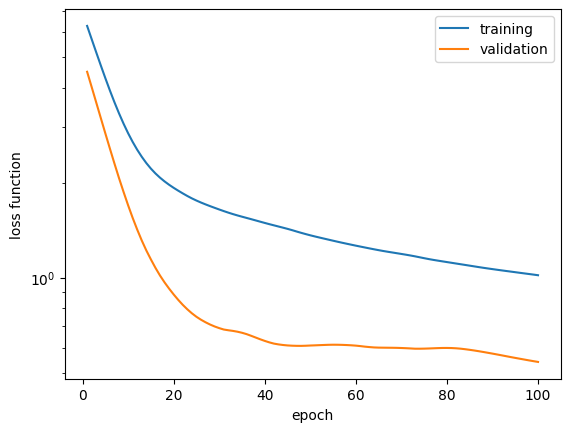

In [30]:
fig,ax = plt.subplots()
trainer.plot_loss(ax, log_yscale=True);

## save the model

In [31]:
filename = "my_ai_model.pt"
torch.save(model,filename)

See the 'inference.ipynb' example notebookt for a more in-depth exploration of an already trained ML model.

### plot the results

Apply the trained model to the validation sample. For a comparison, we also need the background fields in observation space. Therefore we have to apply the forward operators to the background:

In [32]:
from util import move_to_device
result = model(move_to_device(sample,device))

h_fg = model.apply_forward_operators(sample["fg"],sample["obs"])
print("background in observation space:", h_fg)

background in observation space: {'SYNOP': {'values': tensor([[[285.5269,   1.0000,  39.0000,   7.9548,  49.9859],
         [285.7118,   1.0000,  39.0000,   7.9590,  49.9810],
         [286.1626,   1.0000,  39.0000,   8.4536,  49.8537],
         [284.5658,   1.0000,  39.0000,   8.1050,  50.2119],
         [287.5507,   1.0000,  39.0000,   7.5325,  50.3837],
         [284.7422,   1.0000,  39.0000,   7.6528,  50.4528],
         [285.7628,   1.0000,  39.0000,   7.5357,  50.4468],
         [284.5507,   1.0000,  39.0000,   8.0072,  50.2643],
         [283.6815,   1.0000,  39.0000,   7.5981,  49.9996],
         [284.9091,   1.0000,  39.0000,   7.7609,  50.0602],
         [284.7377,   1.0000,  39.0000,   7.6128,  49.7756],
         [284.5472,   1.0000,  39.0000,   7.5749,  49.6384],
         [285.2713,   1.0000,  39.0000,   7.8710,  49.8502],
         [284.8657,   1.0000,  39.0000,   8.0916,  50.0069],
         [285.8040,   1.0000,  39.0000,   8.0075,  49.9512],
         [285.6441,   1.0000,  

Compare the results in observation space. (Note that plotting always needs to be done on the CPU!)

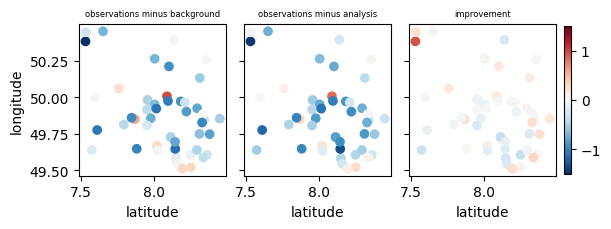

In [33]:
fig,axs = plt.subplots(1,3, constrained_layout=True, sharey=True, figsize=(6,9))

# extract the coordinates:
obs_lon = result["obs"]["SYNOP"]["values"][0,:,3].cpu() # the indices mean: first sample, all observations, third column (=longitude for SYNOP obs)
obs_lat = result["obs"]["SYNOP"]["values"][0,:,4].cpu() # the indices mean: first sample, all observations, fourth column (=latitude for SYNOP obs)

# extract the data:
obs_data  = result["obs"]["SYNOP"]["values"][0,:,0].cpu() # the indices mean: first sample, all observations, first column (=observation)
h_fg_data = h_fg["SYNOP"]["values"][0,:,0].cpu() # the indices mean: first sample, all observations, first column (=observation)
h_an_data = result["h_an"]["SYNOP"]["values"][0,:,0].detach().cpu() # the indices mean: first sample, all observations, first column (=observation)

# for better comparison: set the colorbar
vmin, vmax = -1.5, 1.5
cmap = 'RdBu_r'

# panel 1: observations minus background
axs[0].scatter(obs_lon, obs_lat, c=obs_data-h_fg_data, vmin=vmin, vmax=vmax, cmap=cmap)
axs[0].set_ylabel('longitude')
axs[0].set_title('observations minus background', fontsize=6)

# panel 2: observations minus analys
axs[1].scatter(obs_lon, obs_lat, c=obs_data-h_an_data, vmin=vmin, vmax=vmax, cmap=cmap)
axs[1].set_title('observations minus analysis', fontsize=6)

# panel 3: improvements
axh = axs[2].scatter(obs_lon, obs_lat, c=(obs_data-h_fg_data).abs()-(obs_data-h_an_data).abs(), vmin=vmin, vmax=vmax, cmap=cmap)
axs[2].set_title('improvement', fontsize=6)

# options for all axes
for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlabel('latitude')

# add colorbar
cbar = fig.colorbar(axh, ax=axs[2], orientation='vertical', fraction=.05)
plt.savefig("aivar_o-b_o-a.png")

The `inference.ipny` notebook demonstrates a deeper exploration of a more sohisticated (pre-trained) model.